# Introduction

Set up the environmet for the analysis. Load the file to display results further down

In [97]:
input_path = "../output/benchmark_deps.json"

In [98]:
import json
import pandas as pd

with open(input_path) as f:
    data = json.load(f)

In [99]:
print("This benchmark is comprised of %i instances, with %i successes and a success rate of %f" % (data["size"], data["numSuccesses"], data["numSuccesses"]/data["size"]))

This benchmark is comprised of 43738 instances, with 5939 successes and a success rate of 0.135786


## Statistics for succesful cases

### Distribution of iterations per trail

In [100]:
stats = data["stats"]

iterationsDist = pd.Series(stats["iterationsDist"])

print(iterationsDist)

5      231
10      91
1     3435
6      192
9      115
2      773
7      150
3      474
8      121
4      357
dtype: int64


### Distribution of papers read per trail

In [101]:
papersDist = pd.Series(stats['papersDist'])
print(papersDist)

5      525
10     163
24       7
25       5
14      77
20      26
29       2
1      567
6      421
28       1
38       2
21      23
33       1
9      232
13     114
2      902
34       1
17      41
22      11
27       3
12     145
7      317
3     1040
18      28
16      57
31       1
11     166
26       3
23       3
8      239
30       3
19      42
4      708
15      63
dtype: int64


### Distribution of actions over all

In [102]:
actionDist = pd.Series(stats['actionDist'])
print(actionDist)

EXPLORATION               0
RANDOM                14101
EXPLOITATION              0
EXPLORATION_DOUBLE        0
dtype: int64


A more detailed look at the cases with a path (_Successful_ cases). Preprocess the data and take a look into the structure of the data frame.

In [103]:
successes = [d for d in data['data'] if d['success']]

def num_documents(paths):
    '''
    This function computes the size of minimal set of documents for each path containes in the argument.
    Then it returns the smallest size.
    '''
    def helper(l, r, total):
        cum = l | r
        if len(l & r) > 0:
            return (cum, total)
        else:
            return (cum, total + 1)
        
    totals = list()
        
    for path in paths:
        doc_sets = [{a['document'] for a in edge['attributions']} for edge in path]
        if len(doc_sets) == 1:
            totals.append(1)
        else:
            sumation = 1
            current = doc_sets[0]
            for n in doc_sets[1:]:
                current, sumation = helper(current, n, sumation)
            totals.append(sumation)
    
    return min(totals)

for s in successes:
    s['min_papers'] = num_documents(s['paths'])


f = pd.DataFrame({k: d[k] for k in set(d.keys()).difference({'success', 'paths'})} for d in successes)
f.set_index('id', inplace=True)
print(f.head())
print("Num elements: %i" % f.shape[0])

                   actions  iterations  min_papers  papersRead
id                                                            
WH_train_10  {'RANDOM': 3}           3           2          11
WH_train_18  {'RANDOM': 1}           1           1           7
WH_train_22  {'RANDOM': 3}           3           1           3
WH_train_23  {'RANDOM': 1}           1           1           7
WH_train_24  {'RANDOM': 1}           1           1           2
Num elements: 5939


In [104]:
# Small sanity check. No epoch should've read less than the paper lower bound computer for it.
print(all(f.min_papers <= f.papersRead))

True


Take a look at the paper distributions

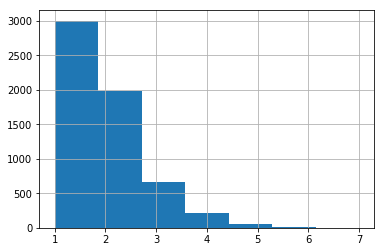

In [105]:
import matplotlib.pyplot as plt
f.min_papers.hist(bins=f.min_papers.max())
plt.show()

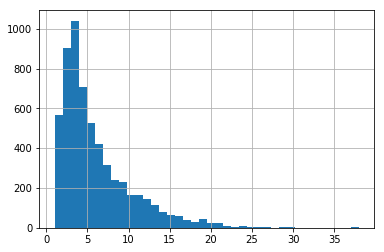

In [106]:
f.papersRead.hist(bins=f.papersRead.max())
plt.show()

Out of the instances finished after one iteration. What is the paper distribution?

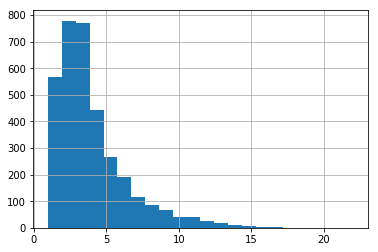

In [107]:
lucky_ones = f[f.actions.map(lambda r: sum(r.values())) == 1]
lucky_ones.papersRead.hist(bins=lucky_ones.papersRead.max())
plt.show()

# Error analysis

In [108]:
# First, isolate the negative cases

failures = [d for d in data['data'] if not d['success']]


s = pd.DataFrame({k: d[k] for k in set(d.keys()).difference({'success', 'paths'})} for d in failures)
s.set_index('id', inplace=True)
print(s.head())
print("Num elements: %i" % s.shape[0])

                   actions  iterations  papersRead
id                                                
WH_train_0  {'RANDOM': 10}          10           5
WH_train_1  {'RANDOM': 10}          10           3
WH_train_2   {'RANDOM': 1}           1           0
WH_train_3   {'RANDOM': 1}           1           0
WH_train_4  {'RANDOM': 10}          10          27
Num elements: 37799


How many of the failures were due to _iteration exhaustion_?

In [109]:
max_iter = s.iterations.max()

exhausted = s[s.iterations == max_iter]

percent = exhausted.shape[0]/s.shape[0]

print("%i out of %i, or %f" % (exhausted.shape[0], s.shape[0], percent))

28316 out of 37799, or 0.749120


The reminder of failures, had the following distribution of iterations:

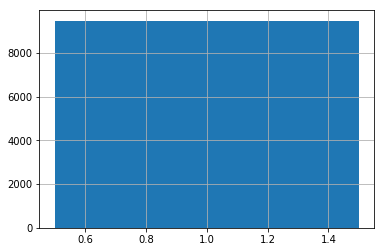

In [110]:
not_exhausted = s[s.iterations != max_iter]
not_exhausted.iterations.hist(bins=not_exhausted.iterations.max())
plt.show()

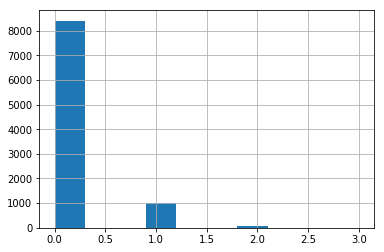

In [112]:
not_exhausted.papersRead.hist()
plt.show()

The explanation for this is that the information retrieval returned a small amount of papers, and no new data was added to the knowledge graph or any other reason that lead to _action starvation_